<a href="https://colab.research.google.com/github/dianabohorquez/spotify/blob/main/TimeSeries_ARIMA_Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

Se propone en este trabajo práctico predecir el comportamiento de dos de las variables que describen características del audio de un set de canciones en Spotify. Se realizan una serie de test estadísticos y análisis gráficos para determinar el modelo ARIMA que mejor describe estas series, se procede a generar el modelo hacer pronósticos con él y medir su performance.
El valor en la selección de estas variables está en trabajar el modelado de series temporales en aplicaciones diferentes a las típicamente usadas como, por ejemplo, forecast de medidas económicas, financieras o el clima.



### Preparación del entorno

In [1]:
# manipulación de data frames y EDA
import pandas as pd
import numpy as np
from datetime import timedelta                                 # diferencia de dos fechas

# visualización
import matplotlib.pyplot as plt
import seaborn as sns

# paquetes estadísticos - modelado de series temporales
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import statsmodels.api as sm                                   # modelos estadísticos
#pip install pmdarima
import pmdarima as pm                                          # modelado automático SARIMA
from statsmodels.tsa.arima_model import ARIMA                  # modelo ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX         # modelo SARIMAX
from pylab import rcParams                                     # descomposicion de series temporales
from statsmodels.tsa.stattools import adfuller, kpss           # test Dickey-Fuller y KPSS
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf  # plot the (P)ACF

import warnings
warnings.filterwarnings("ignore")

In [2]:
# accessing to google
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)   #to attempt to forcibly remount  force_remount

# setting working directory
import os
os.chdir("/content/gdrive/My Drive/Data Scientist/spotify/datasets/")

Mounted at /content/gdrive


# Planteamiento del Problema

Si se refiere a datos de YouTube, Netflix o Spotify instintivamente  cualquiera puede responder qué producción musical o audiovisual  es un hit: si lleva tiempo siendo muy vista o escuchada o si rompió algún record de visitas estamos ante un producto *pop*. Para el caso de Spotify, en su [página de desarrollador](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-audio-features) ellos mencionan, por ejemplo, que la `popularity` de una canción es de hecho un valor calculado por un algoritmo basado, en mayor medida, en la cantidad de reproducciones que tiene una canción. Pero, ¿cómo se puede explicar esta popularidad?

Spotify ha estructurado información no estructurada para *explicar* en términos de datos la música, definiendo variables como `loudness` (volumen general de una pista en dB), `liveness` (probabilidad  que el track se realizó en vivo) o `acousticness` (medida de confianza de si la pista es acústica o no). UUna breve exploración de estas y otras variables se encuentra en la [notebook A01_EDA](https://github.com/dianabohorquez/spotify/blob/main/A01_EDA_Spotify.ipynb).

De acuerdo a esa exploración, a la oportunidad de buscar analizar series de comportamiento no estacionario y a la definición que Spotify da a sus variables, se preseleccionaron para este trabajo práctico `energy` y `valence`.

- **release_date** contiene la fecha de lanzamiento, la mayoría con formato yyyy-mm-dd.
- **energy** con un rango de 0.0 a 1.0 representa una medida perceptiva de intensidad y actividad. Por lo general, las pistas enérgicas se sienten rápidas y ruidosas. Por ejemplo, el death metal tiene mucha energía, mientras que un preludio de Bach tiene una puntuación baja en la escala. Las características de percepción que contribuyen a este atributo incluyen rango dinámico, volumen percibido, timbre, frecuencia de inicio y entropía general.
- **valence**: con un rango de 0.0 a 1.0 `valence` describe la positividad musical que transmite una pista. Las pistas con valencia alta suenan más positivas (por ejemplo, feliz, alegre, eufórico), mientras que las pistas con valencia baja suenan más negativas (para el caso de adjetivos como triste, deprimido, enojado).

Varios datasets de Spotify están disponible en [Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks). Particularmente para este trabajo práctico se utilizará  `data_o.csv`, renombrado `spotify_o.csv.zip`

Es interés para este trabajo práctico pronosticar el comportamiento futuro de estas tres variables haciendo uso de análisis de series temporales.

In [3]:
# importación de datos
spotify = pd.read_csv('spotify_o.csv.zip', usecols=['release_date', 'energy', 'valence'])

# Habilitando el dataframe para trabajarlo como una serie temporal
spotify.release_date = pd.to_datetime(spotify.release_date)
spotify.set_index('release_date', inplace=True)

# Análisis Exploratorio de los Datos y Preprocesamiento

En general este data set parece limpio. No tiene valores ausentes, aparentemente sus datos son consistentes presentan muy pocos outliers y su distribución tiende a estar normalizada. Otros datos relevantes del data set son:

- La base de datos consta de 170.653 registros y 2 variables.
- No todas las canciones tienen la fecha de lanzamiento completo (algunas solo el año).
- Las observaciones van del año 1921 a 2020.
- No hay valores faltantes o nulos
- La naturaleza de los datos parece estandarizada.

In [4]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 170653 entries, 1921-01-01 to 2020-10-16
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   valence  170653 non-null  float64
 1   energy   170653 non-null  float64
dtypes: float64(2)
memory usage: 3.9 MB


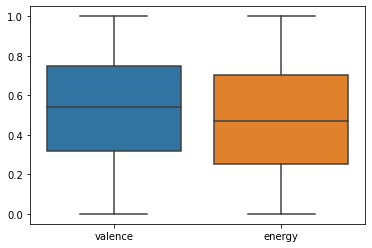

In [5]:
sns.boxplot(data=spotify);

**Tanto la variable `valence` como `energy` podría pensarse con variables con distribuciones uniformes.**

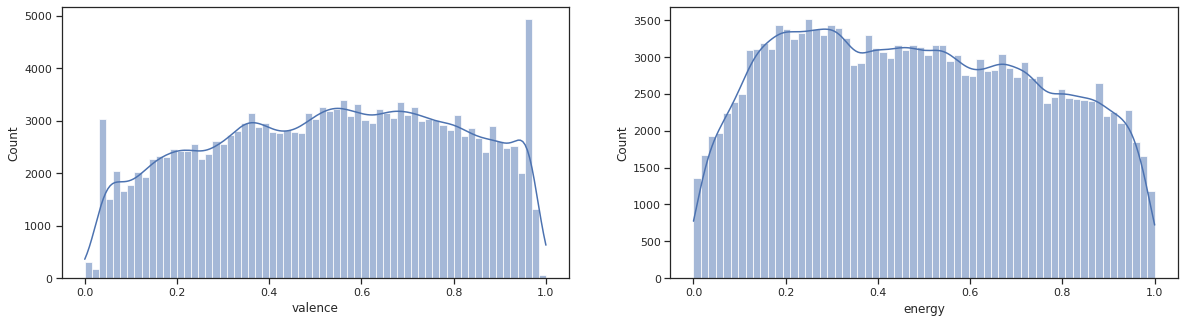

In [6]:
sns.set_theme(style="ticks")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

sns.histplot(data=spotify, x="valence", kde=True, ax=axs[0]);
sns.histplot(data=spotify, x="energy", kde=True, ax=axs[1]);

**Al graficar en un histograma (haciendo un corte entre 1975 y 1977, y 2006 y 2008) la cantidad de canciones que se lanzaron mensualmente, hay un interesante patrón que muestra como en enero se hacían en promedio nueve veces más lanzamientos que en los otros meses.**

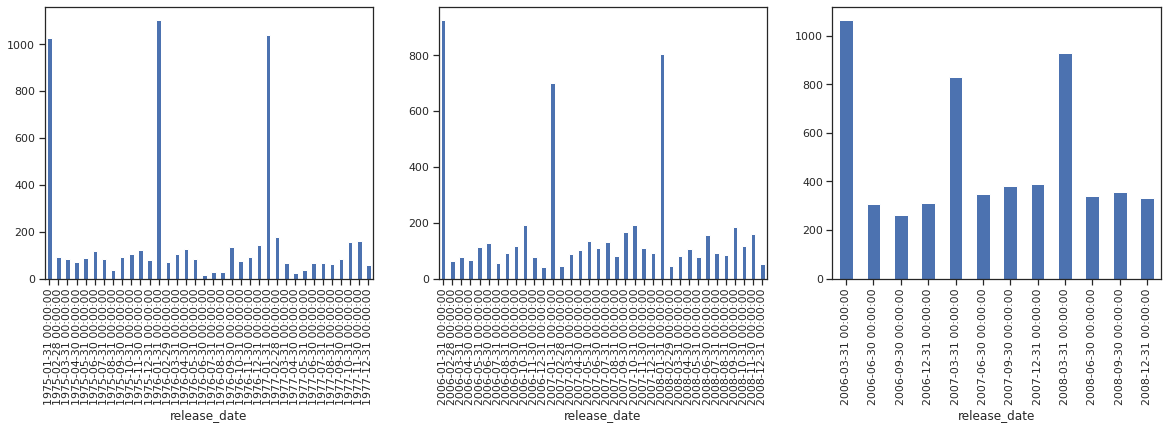

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

spotify['energy'].groupby(pd.Grouper(freq="M")).count().loc['1975':'1977'].plot(kind="bar", ax=axs[0]);
spotify['energy'].groupby(pd.Grouper(freq="M")).count().loc['2006':'2008'].plot(kind="bar", ax=axs[1]);
spotify['energy'].groupby(pd.Grouper(freq="Q")).count().loc['2006':'2008'].plot(kind="bar", ax=axs[2]);

**Por último y con el objeto de decidir la ventana temporal y la frecuencia en la que se trabajarán las series temporales se grafica cada variable promediando su valor anual.**

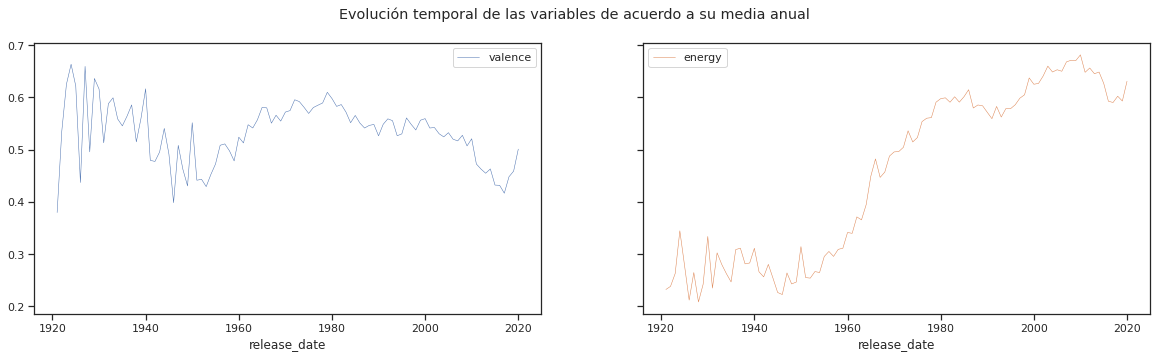

In [8]:
spotify.groupby(spotify.index.year).mean().plot(subplots=True
                                                , linewidth=0.5, layout=(1,2), figsize=(20, 5)
                                                , sharex=False, sharey=True
                                                , title = 'Evolución temporal de las variables de acuerdo a su media anual');

En resumen, algunas de las características observadas en este apartado exploratorio son:

- Con periodicidad anual las señales se suavisan siendo menos ruidosas.
- Con el pasar de los años los valores tienen menos variabilidad.
- Cerca y después del año 1960 la información parece menos errática.
- Visualmente se puede decir que ningunas de las dos series es estacionaria.
- Hay una aparente estacionalidad presente anualmente en los meses de enero. Esta variación periódica podría también representarse trimestralmente.

Considerando todas estas observaciones se define como dataset de interés los datos a partir de 1960 y agrupados trimestralmente.

In [9]:
# Eliminado los datos menores a 1960 (inclusive) y agrupándolos según su promedio trimestral
spotify = spotify.groupby(pd.Grouper(freq="Q")).mean()
spotify = spotify.iloc[160:,]

# Marco Teórico

El objetivo de este TP es pronosticar el comportamiento de tres variables que definen características del audio de  algunas de las canciones disponibles en Spotify.

## Propiedades de las series temporales

Visualmente ninguna de las series parece estacionaria, ya que por lo pronto se evidencian en ellas cierta tendencia,  en `valence` por ejemplo, una negativa y en `energy` una positiva. Para testear la hipótesis de estacionariedad se correrán test de raíces unitarias.

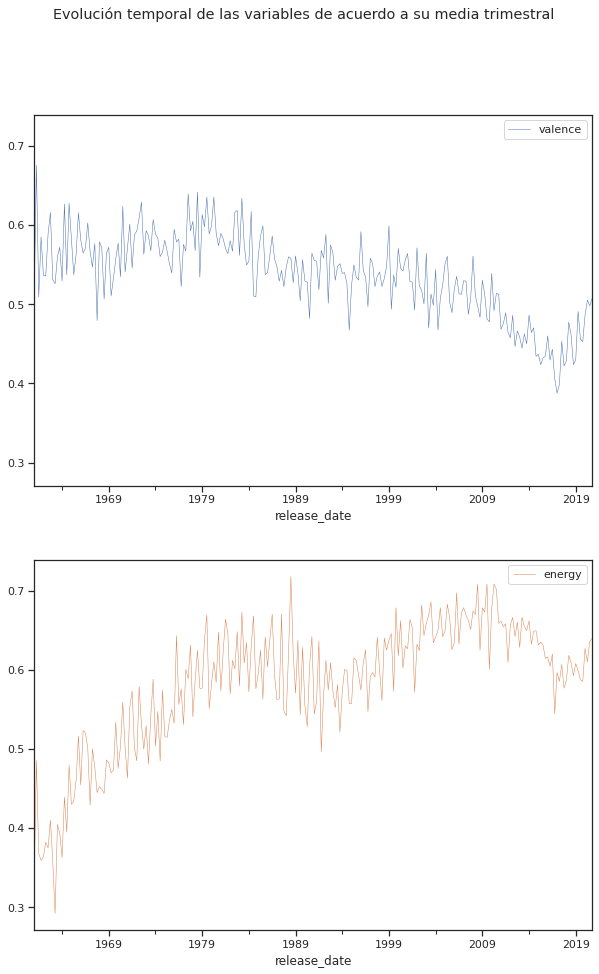

In [10]:
spotify.plot(subplots=True
             , linewidth=0.5, layout=(2, 1), figsize=(10, 15)
             , sharex=False, sharey=True
             , title = 'Evolución temporal de las variables de acuerdo a su media trimestral');

### Descomposición y test de estacionariedad ➡ variable Valence 😄

Al analizar una a una las componentes de la descomposición de la variable `valence` se observa:
- Una ligera **tendencia** positiva hasta el año 1980 y notablemente negativa de 1980 a 2008 aproximadamente. Esta tendencia puede ser capturada por el modelo incluyendo una componente autorregresiva AR.
- Parece haber un claro patrón **estacional** en la serie fluctuando entre los valores 0.0075 y -0.0075. Intuitivamente se puede pensar que esto está presente en los lanzamientos anuales (cada enero o primer trimestre) que son claramente superiores a los demás meses del año. Esta señal puede ser modelada trabajando con un modelo SARIMA.
- No sé aprecia un patrón en los residuos.

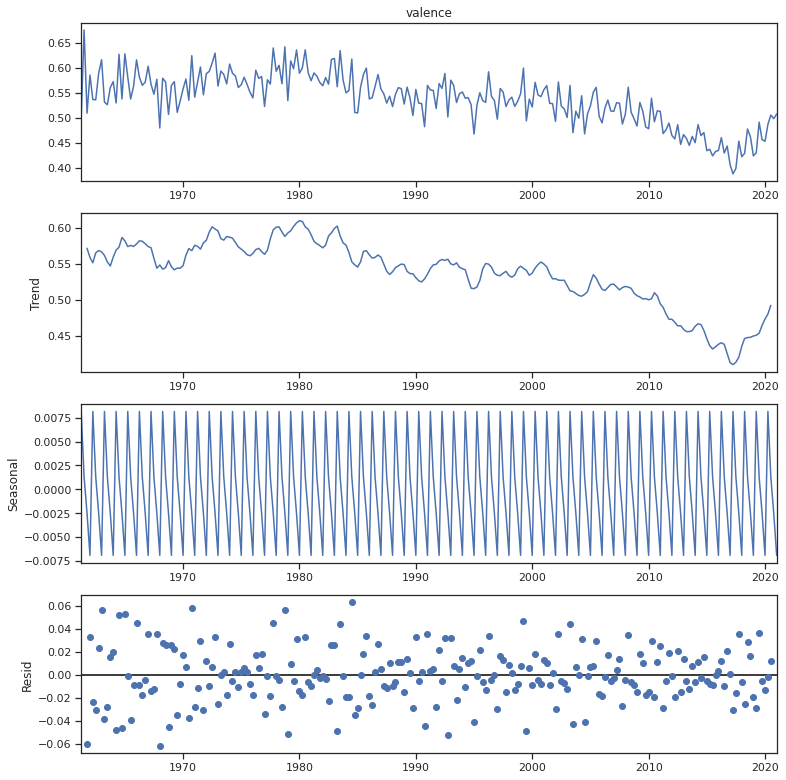

In [11]:
# Descomposicion de la serie temporal Valence
rcParams['figure.figsize'] = 11, 11
decomposeValence = sm.tsa.seasonal_decompose(spotify['valence'])
fig = decomposeValence.plot();

Para comprobar lo observado gráficamente se corre el test ADF obteniendo como *p-value 0.3980* con lo cual no se puede rechazar H0 de tal forma que no se puede asumir estacionariedad en la serie.

In [12]:
v_adfuller = adfuller(spotify['valence'])
print('p-value del test adfuller para valence: ', v_adfuller[1])

p-value del test adfuller para valence:  0.3980382475045702


Este resultado implica que la serie debe ser diferenciada para hacerla estacionaria. Después de esta transformación y analizando los gráficos de función de autocorrelación y autocorrelación parcial se tendrá una idea del modelo (AR, MA, ARMA o ARIMA) y su orden.

In [13]:
# Aplicando diferencia al dataset
spotifyDiff = spotify.diff().dropna()

In [14]:
sav_adfuller = adfuller(spotifyDiff['valence'])
print('p-value test adfuller quarter valence: ', sav_adfuller[1], '-> entonces no rechazamos H0, por lo tanto la serie es un random walk')

p-value test adfuller quarter valence:  2.9421281845410765e-30 -> entonces no rechazamos H0, por lo tanto la serie es un random walk


### Descomposición y test de estacionariedad ➡ variable Energía ⚡ 

Para el caso de la variable `energy`  se analiza lo siguiente de las componentes de la serie:

- Hay una clara tendencia positiva al pasar los años.
- Igual que en `valence` parece claro la existencia de estacionalidad en las series.
- Los residuos también parecen aleatorios.

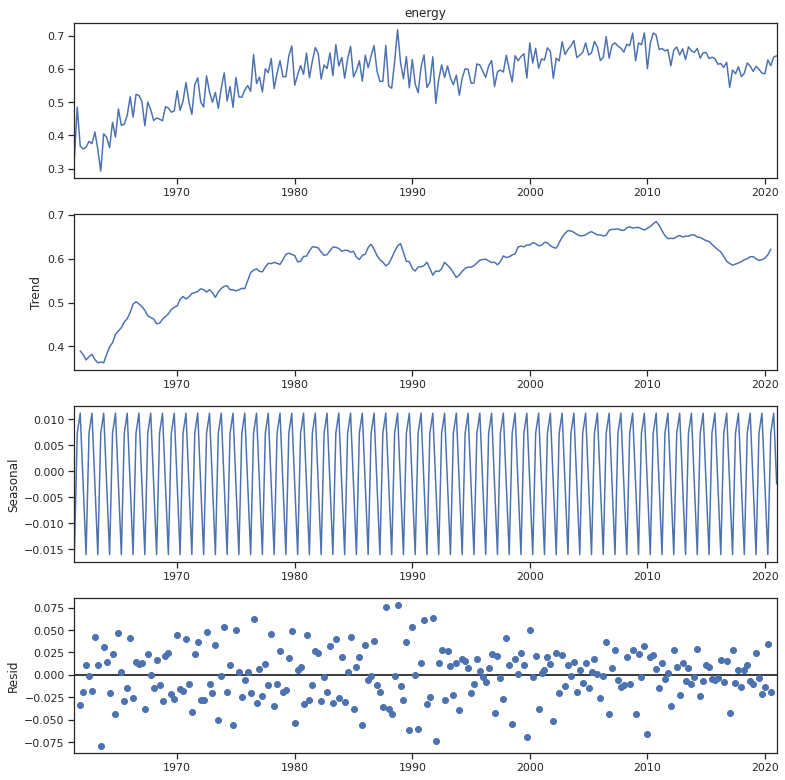

In [15]:
# Descomposicion de la serie temporal Energy
rcParams['figure.figsize'] = 11, 11
decomposeValence = sm.tsa.seasonal_decompose(spotify['energy'])
fig = decomposeValence.plot();

Para el caso de `energy` el test ADF arroja un *p-value de 0.01715* rechazando H0, por lo tanto, la serie no es un random walk, entonces la serie es estacionaria.

In [16]:
e_adfuller = adfuller(spotify['energy'])
print('p-value del test adfuller para energy: ', e_adfuller[1])

p-value del test adfuller para energy:  0.017150791572558437


Este resultado es llamativo a la vista del análisis de descomposición de la serie. Algunas de las razones que pueden estar detrás de este resultado es que el test tiene poco poder en distinguir entre raíces unitarias y raíces unitarias cercanas o los datos puedan ser pocos para el test.

Una alternativa a este test es el **KPSS Test** que para el caso de la serie `energy` el *p-value es de 0.01*.

In [17]:
kpsstest = kpss(spotify['energy'])
print('p-value del test kpss para energy: ', kpsstest[1])

p-value del test kpss para energy:  0.01


Estos dos resultados, tanto el de ADF y KPSS, rechazan la hipótesis nula sobre la alternativa, por lo tanto, la serie no es estacionaria.

A partir de estos tests y graficando las funciones de autocorrelación y autocorrelación parcial sin diferenciar la serie se podrá tener una idea del orden del modelo.

## 2. Función de Autocorrelación

*Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de los gráficos?. Justificar con teoría.*

La autocorrelación es un valor numérico (rango -1 a 1) que indica cuánto una serie temporal está correlacionada consigo misma separada por un específico número de periodos, denominados lags. **La función de autocorrelación (ACF)** permite observar esta correlación considerando diferentes retardos. Algunos de sus usos son:

- Cualquier autocorrelación (estadísticamente) significante implica que la serie puede ser pronosticada considerando su pasado.
- Se pueden observar que lags específicos contribuyen al modelo.
- Se observan también comportamientos estacionales
- Ayudan a seleccionar las órdenes del modelo que mejor se ajustará a los datos.
    - Para el caso de los modelos MA se debe observar la función de autocorrelación, mientras que,
    - La función de autocorrelación parcial ayudan a identificar el orden para el modelo AR

### Análisis de Autocorrelación ➡ variable Energía ⚡

La gráfica de autocorrelación de `energy` muestra que sus observaciones sucesivas están correlacionadas positivamente, pero al no decrecer rápidamente hacia cero sugiere que el proceso tiene efectivamente una tendencia con lo cual no sería estacionario ni el gráfico informativo.

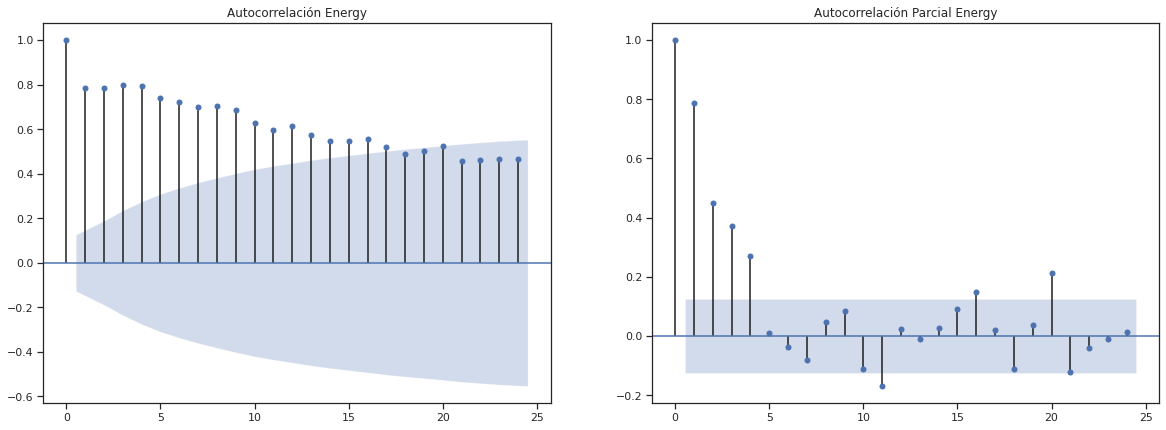

In [18]:
# Gráfica ACF y PACF de energy
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
plot_acf(spotify['energy'], ax=axes[0], title='Autocorrelación Energy');
plot_pacf(spotify['energy'], ax=axes[1], title='Autocorrelación Parcial Energy');

Al diferenciar la variable parece corregirse la no estacionariedad sugerida en el FAC inicial y que un modelo funcional sería el MA(1). Para el caso de la FACP se estaría ante un modelo AR(4). En el lag 20 de la función de autocorrelación puede haber indicios de estacionalidad de la serie.

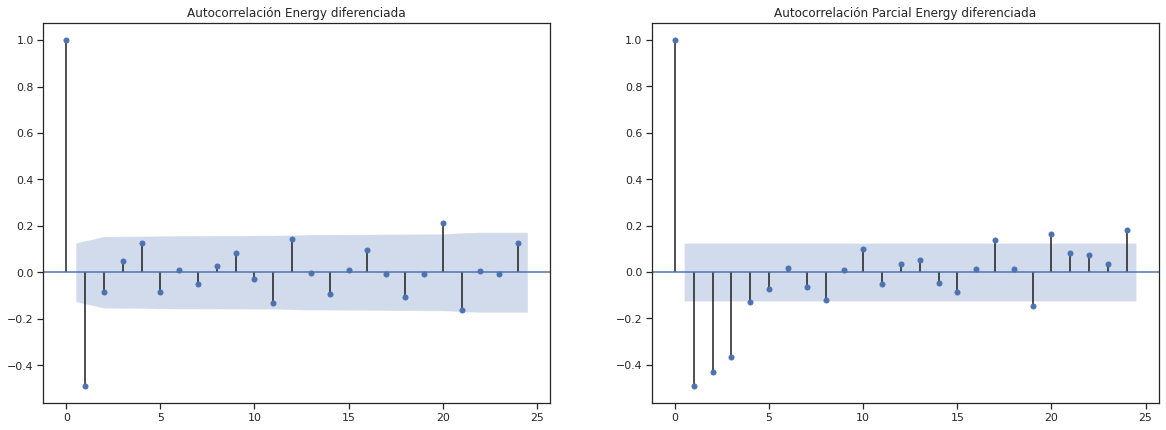

In [19]:
# Gráfica ACF y PACF de energy
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
plot_acf(spotifyDiff['energy'], ax=axes[0], title='Autocorrelación Energy diferenciada');
plot_pacf(spotifyDiff['energy'], ax=axes[1], title='Autocorrelación Parcial Energy diferenciada');

### Análisis de Autocorrelación  ➡ variable Valence 😄

Para el caso de `valence` la función de autocorrelación sugiere un modelo MA(1) y la de autocorrelación parcial uno AR(3). En este análisis no se identifican categóricamente componentes de estacionalidad.

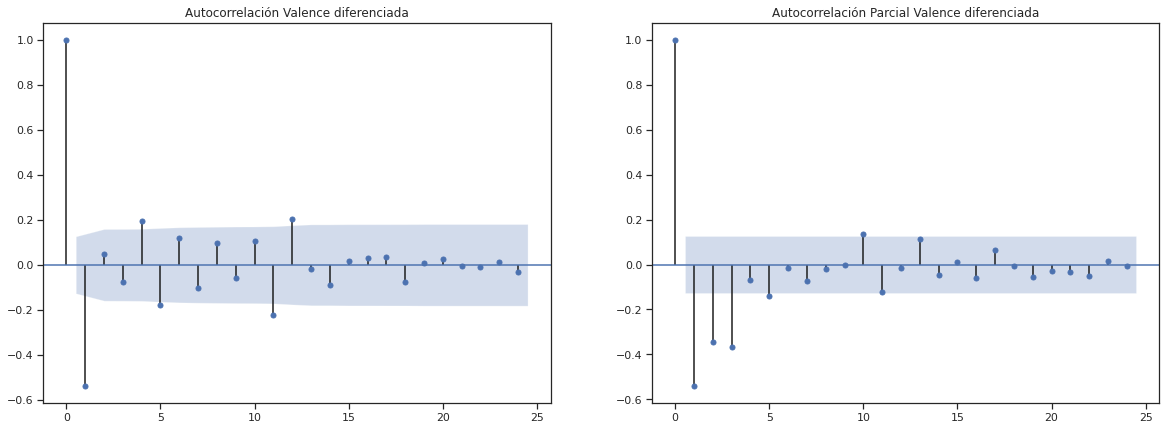

In [20]:
# Gráfica ACF y PACF de valence con la serie original y diferenciada
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
plot_acf(spotifyDiff['valence'], ax=axes[0], title='Autocorrelación Valence diferenciada');
plot_pacf(spotifyDiff['valence'], ax=axes[1], title='Autocorrelación Parcial Valence diferenciada');

## Modelado ➡ variable Energía ⚡


*En este apartado se realizará una estimación de las series temporales con distintos órdenes para un modelo ARIMA, dado que no se encontró evidencia en de estacionalidad en la función de autocorrelación para plantear modelo SARIMA. Con el objeto de analizar el desempeño del modelo las series serán separadas en entrenamiento y test.*

In [21]:
# Split los datos en entrenamiento (70%) y test (30%)
spotify_train = spotify.loc[:'2002']
spotify_test = spotify.loc['2003':]

# Index de las fechas de test
dates_test = spotify_test.index

### Estimando el orden del modelo

*Efectuar una estimación de la serie temporal con distintos órdenes de parámetros de modelos (S)ARIMA y encontrar aquel que se ajuste mejor a los datos (pueden emplear Criterios de Información y analizar significatividad individual y global de los parámetros del modelo).*

Considerando el análisis hecho sobre las funciones de autocorrelación se iterará sobre modelos hasta de órdenes AR(4) y MA(10) para la variable `energy`; a pesar de que los test de no estacionariedad indicaron que esta serie es estacionaria, la función de autocorrelación indicaba no estacionariedad razón por la cual también se iterará por un orden I(1).

In [ ]:
# Estimando el mejor modelo ARIMA para energy
order_energy =[]
# Loop sobre orden de AR
for p in range(5):
    # Loop sobre orden de Integración
    for d in range(2):
        # Loop sobre orden de MA
        for q in range (11):
            try:
                # Ajuste del modelo modelo
                model = SARIMAX(spotify_train['energy'], order=(p,d,q))
                results = model.fit()
                # impresión del orden del modelo con valores AIC/BIC
                print(p, d, q, results.aic, results.bic)
                # Sumar orden y resultados a la lista
                order_energy.append((p, d, q, results.aic, results.bic))
            except:
                # Impresión de AIC y BIC como None cuando el modelo falla
                print(p, d, q, None, None)
 
# Creación de dataframe con los órdenes del modelo y los resultados de AIC/BIC
order_df_energy = pd.DataFrame(order_energy, columns=['p', 'd', 'q', 'aic', 'bic'])

### Selección del Modelo y Análisis de Diagnóstico

Según los Criterios de Información los mejores modelos podrían ser ARIMA(0,1,3), ARIMA(2,1,1) o (4,1,4). Interesante de este experimento es el hecho que efectivamente la serie necesitaría diferenciarse para poder tener un mejor ajuste.

In [23]:
print(order_df_energy.sort_values('bic').head(5))

    p  d  q         aic         bic
14  0  1  3 -583.934053 -571.462077
56  2  1  1 -583.459311 -570.987336
13  0  1  2 -580.147312 -570.793331
12  0  1  1 -576.187976 -569.951989
35  1  1  2 -581.582647 -569.110672


In [24]:
print(order_df_energy.sort_values('aic').head(5))

     p  d  q         aic         bic
103  4  1  4 -584.427530 -556.365586
14   0  1  3 -583.934053 -571.462077
78   3  1  1 -583.548711 -567.958742
56   2  1  1 -583.459311 -570.987336
57   2  1  2 -583.078310 -567.488341


**Corriendo un `auto_arima` se sugiere también que un bueno modelo sería el ARIMA(2,1,1)**

In [25]:
e_autoarima = pm.auto_arima(spotify_train['energy'], seasonal=True)
e_autoarima

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

**Haciendo una comparación de estos tres modelos se tiene el siguiente resumen:**

| Modelo | AIC | BIC | Ljung-Box (L1) (Q) | Prob(Q) | Jarque-Bera (JB) | Prob(JB)|
| - | - | - | - | - | - | - |
| ARIMA(0,1,3) | -583.934 | -571.462 | 0.02 | 0.89 | 0.79 | 0.97 |
| ARIMA(2,1,1) | -583.459 | -570.987 | 0.19 | 0.66 | 0.72 | 0.70 |
| ARIMA(4,1,4) | -584.428 | -556.366 | 0.00 | 1.0 | 0.52 | 0.77 |

- Dado el valor de AIC del modelo ARIMA(0,1,3) se puede inferir que este es el mejor predictor.
- Dado el valor de BIC del modelo ARIMA(4,1,4) se puede inferir que este es el que mejor explica al modelo.
- Dado los valores de p-value de JB no se puede rechazar la hipótesis nula que los residuos están normalmente distribuidos.
- Para el caso de los p-value de Ljung-Box no se puede rechazar la hipótesis nula que los residuos estén correlacionados, por lo tanto no quedan señales sin capturar en el modelo.

Primando por un modelo parsimonioso se elige el modelo ARIMA(0,1,3) para la serie de `energy`.

$\hat{y}_{t} = -0.936_{\epsilon_{t-1}}+0.185_{\epsilon_{t-3}}$

In [26]:
# Modelo ARIMA para energy
arima_energy = SARIMAX(spotify_train['energy'], order=(0,1,3))
arima_energy_results = arima_energy.fit()
print(arima_energy_results.summary())

                               SARIMAX Results                                
Dep. Variable:                 energy   No. Observations:                  168
Model:               SARIMAX(0, 1, 3)   Log Likelihood                 295.967
Date:                Sun, 01 Aug 2021   AIC                           -583.934
Time:                        00:01:46   BIC                           -571.462
Sample:                    03-31-1961   HQIC                          -578.872
                         - 12-31-2002                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9360      0.088    -10.605      0.000      -1.109      -0.763
ma.L2          0.0411      0.117      0.352      0.725      -0.188       0.270
ma.L3          0.1846      0.083      2.224      0.0

**Viendo visualmente los residuos se comprueba que efectivamente estos están normalmente distribuidos, no presentan patrón y no hay una correlación entre ellos.**

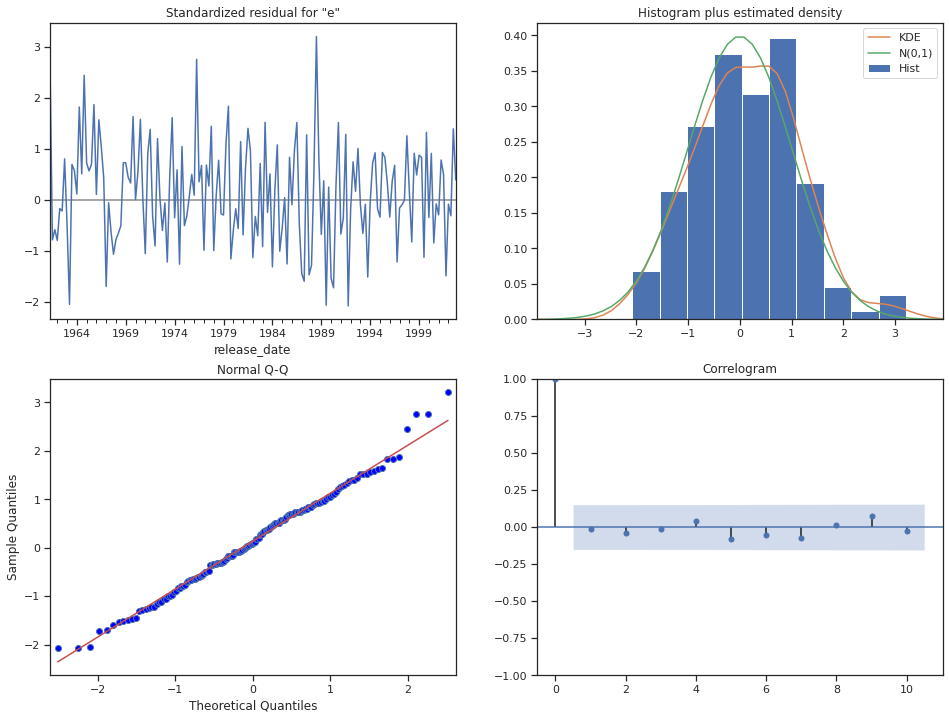

In [27]:
arima_energy_results.plot_diagnostics(figsize=(16, 12));

### Pronóstico con el modelo

Usando los resultados de entrenamiento se hace pronóstico sobre los datos de dataset de testeo, considerando que el modelo seleccionado ARIMA(0,1,3)

In [28]:
# Pronóstico con modelo entrenado con training data
# Crear objeto forecast
e_forecast = arima_energy_results.get_forecast(steps=72)   # 72 pasos hay en test

# Extraer el atributo predicted mean
e_meanForecast = e_forecast.predicted_mean
# otra forma de tener e_meanForecast:
# e_predictions = arima_energy_results.predict(start=spotify_test['energy'].index[0], end=spotify_test['energy'].index[-1])
e_residuals = spotify_test['energy'] - e_meanForecast

# Calcular los intervalos de confianza
e_conf_int = e_forecast.conf_int()

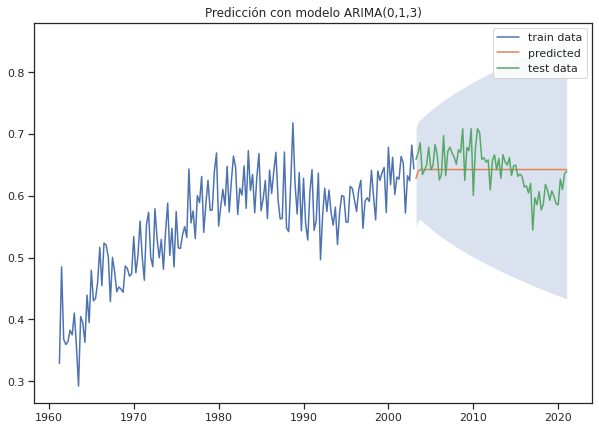

In [29]:
# Graficar datos de entrenamiento, test, y pronóstico
# Plot past
plt.figure(figsize=(10, 7))
plt.plot(spotify_train.index, spotify_train['energy'], label='train data');

# Graficar la predicción como una línea
plt.plot(dates_test, e_meanForecast, label='predicted');
plt.plot(spotify_test['energy'], label='test data')

# Sombra en los intervalos de confianza
plt.fill_between(dates_test, e_conf_int['lower energy'], e_conf_int['upper energy'], alpha=0.2);

# Plot legend and show figure
plt.legend()
plt.title('Predicción con modelo ARIMA(0,1,3)');

La predicción para esta serie temporal no resulta buena gráficamente hablando. Aunque en el principio puede que se acerque la predicción un poco más al dato realmente observado y con el tiempo pierda precisión estableciendo la predicción en la media, es un comportamiento esperado en las series temporales que en la medida que se quiere predecir valores más lejanos al último observado el modelo se vuelve cada vez menos eficiente en las predicciones.

Algunas métricas acerca de la precisión del modelo son:
- MSE: 0.028107
- MAE: 0.001180
- RMSE: 0.034350

In [30]:
# Mean Absolute Error and Mean Squared Error
e_mae = mean_absolute_error(spotify_test['energy'], e_meanForecast)
e_mse = mean_squared_error(spotify_test['energy'], e_meanForecast)
e_rmse = sqrt(e_mse)
print('MSE: %f' % e_mae)
print('MAE: %f' % e_mse)
print('RMSE: %f' % e_rmse)

MSE: 0.028107
MAE: 0.001180
RMSE: 0.034350


**En la gráfica de AFC se sugirió un componente estacional en el lag 20. Se corrió un experimento para ver su contribución a las predicciones y gráficamente parece acompañar mejor el resultado, pero los resultados de precisión claramente empeoraron.**

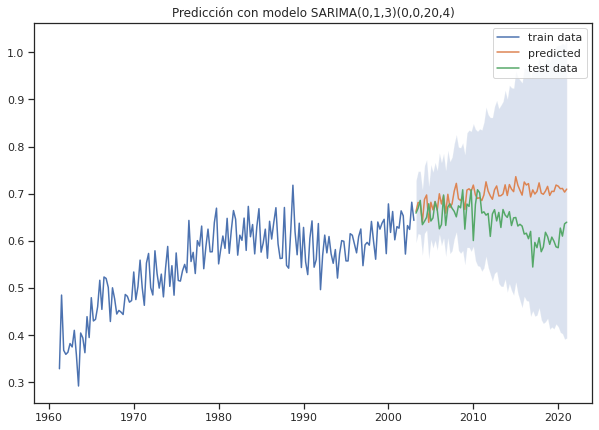

In [ ]:
#@title
# Graficar datos de entrenamiento, test, y pronóstico
# Plot past
plt.figure(figsize=(10, 7))
plt.plot(spotify_train.index, spotify_train['energy'], label='train data');

# Graficar la predicción como una línea
plt.plot(dates_test, e_meanForecast, label='predicted');
plt.plot(spotify_test['energy'], label='test data')

# Sombra en los intervalos de confianza
plt.fill_between(dates_test, e_conf_int['lower energy'], e_conf_int['upper energy'], alpha=0.2);

# Plot legend and show figure
plt.legend();
plt.title('Predicción con modelo SARIMA(0,1,3)(0,0,20,4)');

In [ ]:
#@title
# Mean Absolute Error and Mean Squared Error
e_mae = mean_absolute_error(spotify_test['energy'], e_meanForecast)
e_mse = mean_squared_error(spotify_test['energy'], e_meanForecast)
e_rmse = sqrt(e_mse)
print('MSE: %f' % e_mae)
print('MAE: %f' % e_mse)
print('RMSE: %f' % e_rmse)

MSE: 0.058761
MAE: 0.005054
RMSE: 0.071094


**Una forma de compensar esta pérdida de precisión en las predicciones de series temporales es usar el método de rolling forecast origin en el cual el origen o inicio de la predicción se está actualizando de periodo en periodo.**

In [31]:
# create the model
predictions_rolling = pd.Series()
for end_date in spotify_test['energy'].index:
    train_data = spotify['energy'][pd.to_datetime('1961-03-31'):][:end_date - timedelta(days=1)]
    model = SARIMAX(train_data, order=(0, 1, 3))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]

residuals_rolling = spotify_test['energy'] - predictions_rolling

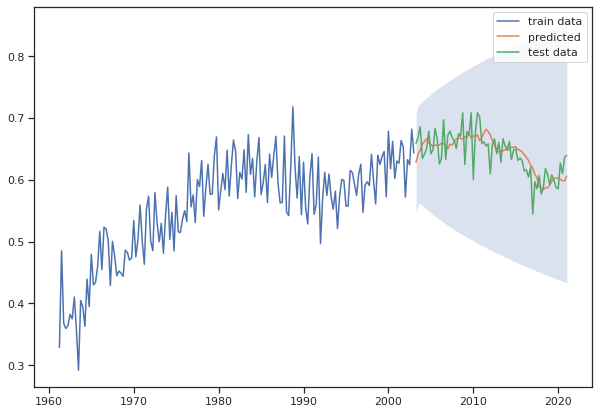

In [32]:
# Graficar datos de entrenamiento, test, con rolling forecast
# Plot past
plt.figure(figsize=(10, 7))
plt.plot(spotify_train.index, spotify_train['energy'], label='train data');

# Graficar la predicción como una línea
plt.plot(dates_test, predictions_rolling, label='predicted');
plt.plot(spotify_test['energy'], label='test data')

# Sombra en los intervalos de confianza
plt.fill_between(dates_test, e_conf_int['lower energy'], e_conf_int['upper energy'], alpha=0.2);

# Plot legend and show figure
plt.legend();

**Visiblemente en este caso mejoran las distintas medidas que hablan de la precisión del modelo.**

In [33]:
# Mean Absolute Error and Mean Squared Error
e_pr_mae = mean_absolute_error(spotify_test['energy'], predictions_rolling)
e_pr_mse = mean_squared_error(spotify_test['energy'], predictions_rolling)
e_pr_rmse = sqrt(e_pr_mse)
print('MSE: %f' % e_pr_mae)
print('MAE: %f' % e_pr_mse)
print('RMSE: %f' % e_pr_rmse)

MSE: 0.020059
MAE: 0.000637
RMSE: 0.025233


**Extendiendo la ventana de tiempo un par de años se puede predecir la evolución de `energy` hasta 2025. La selección de tan corto periodo se debe a que estamos hablando de un modelo de corta memoria**

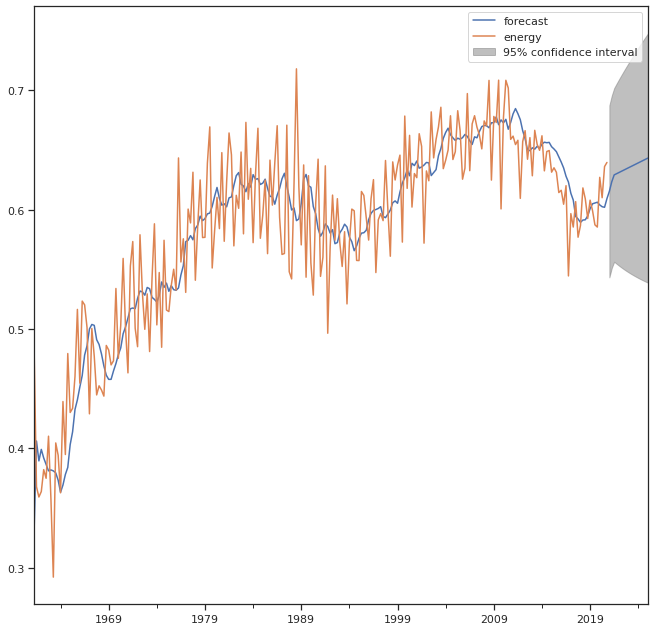

In [34]:
e_mod_arima = ARIMA(spotify['energy'], order=(0, 1, 3))
e_res_arima = e_mod_arima.fit()
e_res_arima.plot_predict(start='1961', end='2025');

## Modelado ➡ variable Valence 😄

### Estimando el orden del modelo

Según las FAC y FACP el modelo sugerido para `valence` es un AR(3) y MA(1); el test de Augmented Dickey-Fuller había rechazado la H0 con lo cual este modelo tiene un orden de integración I(1)

In [ ]:
# Estimando el mejor modelo ARIMA para valence
order_valence =[]
# Loop sobre orden de AR
for p in range(4):
    # Loop sobre orden de Integración
    for d in range(2):
        # Loop sobre orden de MA
        for q in range (2):
            try:
                # Ajuste del modelo modelo
                model = SARIMAX(spotify_train['valence'], order=(p,d,q))
                results = model.fit()
                # impresión del orden del modelo con valores AIC/BIC
                print(p, d, q, results.aic, results.bic)
                # Sumar orden y resultados a la lista
                order_valence.append((p, d, q, results.aic, results.bic))
            except:
                # Impresión de AIC y BIC como None cuando el modelo falla
                print(p, d, q, None, None)
 
# Creación de dataframe con los órdenes del modelo y los resultados de AIC/BIC
order_df_valence = pd.DataFrame(order_valence, columns=['p', 'd', 'q', 'aic', 'bic'])

### Selección del Modelo y Análisis de Diagnóstico

Según los Criterios de Información los mejores modelos podrían ser ARIMA(1,1,1), ARIMA(0,1,1) o ARIMA(2,1,1).

In [36]:
print(order_df_valence.sort_values('bic').head(5))

    p  d  q         aic         bic
7   1  1  1 -667.833118 -658.479136
3   0  1  1 -664.181690 -657.945702
11  2  1  1 -665.988986 -653.517011
5   1  0  1 -660.547549 -651.175657
9   2  0  1 -662.510735 -650.014879


In [37]:
print(order_df_valence.sort_values('aic').head(5))

    p  d  q         aic         bic
7   1  1  1 -667.833118 -658.479136
11  2  1  1 -665.988986 -653.517011
15  3  1  1 -665.280921 -649.690952
3   0  1  1 -664.181690 -657.945702
9   2  0  1 -662.510735 -650.014879


**Haciendo una comparación de estos tres modelos se tiene el siguiente resumen:**

| Modelo | AIC | BIC | Ljung-Box (L1) (Q) | Prob(Q) | Jarque-Bera (JB) | Prob(JB)|
| - | - | - | - | - | - | - |
| ARIMA(1,1,1) | -667.833 | -658.479 | 0.09 | 0.77 | 6.56 | 0.04 |
| ARIMA(0,1,1) | -664.182 | -657.946 | 2.84 | 0.09 | 12.84 | 0.00 |
| ARIMA(2,1,1) | -665.989 | -653.517 | 0.10 | 0.76 | 7.25 | 0.03 |

- Dado el valor de AIC del modelo ARIMA(1,1,1) se puede inferir que este es el mejor predictor.
- Dado el valor de BIC del modelo ARIMA(1,1,1) se puede inferir que este es el que mejor explica al modelo.
- Dado los valores de p-value de JB se puede rechazar la hipótesis nula que los residuos están normalmente distribuidos.
- Para el caso de los p-value de Ljung-Box no se puede rechazar la hipótesis nula que los residuos estén correlacionados, por lo tanto no quedan señales sin capturar en el modelo.

Primando por un modelo parsimonioso se elige el modelo ARIMA(1,1,1) para la serie de `valence`.

$\hat{y}_{t} = -0.215_{t-1}-0.833_{\epsilon_{t-1}}$

In [38]:
# Modelo ARIMA para valence
arima_valence = SARIMAX(spotify_train['valence'], order=(1,1,1))
arima_valence_results = arima_valence.fit()
print(arima_valence_results.summary())

                               SARIMAX Results                                
Dep. Variable:                valence   No. Observations:                  168
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 336.917
Date:                Sun, 01 Aug 2021   AIC                           -667.833
Time:                        00:03:54   BIC                           -658.479
Sample:                    03-31-1961   HQIC                          -664.037
                         - 12-31-2002                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2153      0.087     -2.463      0.014      -0.387      -0.044
ma.L1         -0.8330      0.061    -13.668      0.000      -0.952      -0.714
sigma2         0.0010   9.98e-05     10.274      0.0

**A pesar que el test de Jarque-Bera sugiere que los residuos no están normalmente distribuidos, el gráfico de estos si los muestra normalizados. En este caso, una posible solución es ver de cerca los outliers que presenta la serie.**

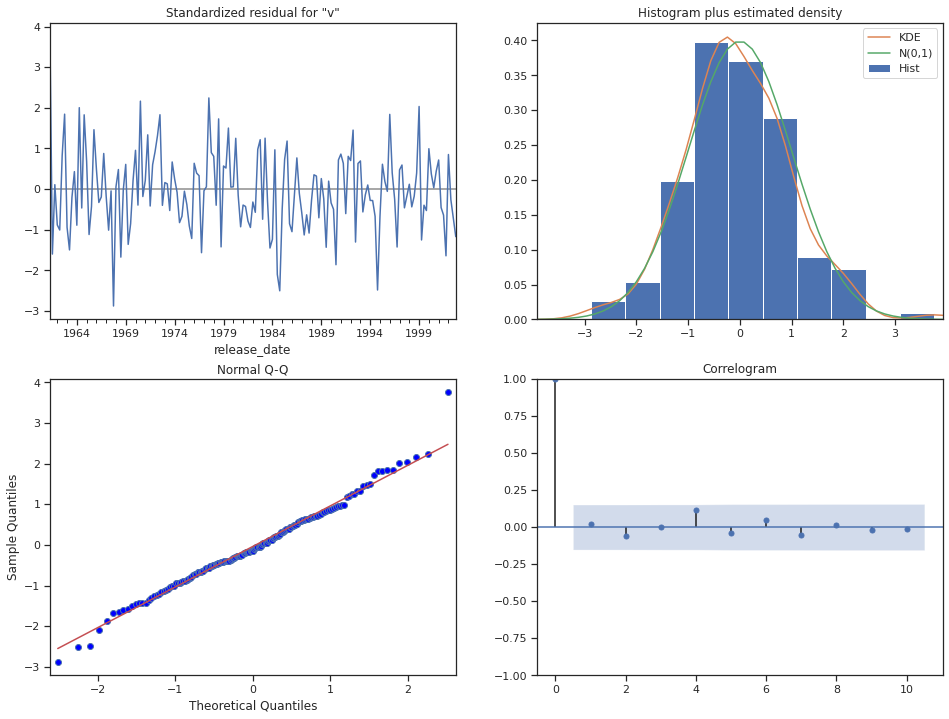

In [39]:
arima_valence_results.plot_diagnostics(figsize=(16,12));

### Pronósticos con el modelo

Usando los resultados de entrenamiento se hace pronóstico sobre los datos de dataset de testeo, considerando que el modelo seleccionado ARIMA(1,1,1)

In [40]:
# Pronóstico con modelo entrenado con training data
# Crear objeto forecast
v_forecast = arima_valence_results.get_forecast(steps=72)   # 72 pasos hay en test

# Extraer el atributo predicted mean
v_meanForecast = v_forecast.predicted_mean
# otra forma de tener e_meanForecast:
# e_predictions = arima_energy_results.predict(start=spotify_test['energy'].index[0], end=spotify_test['energy'].index[-1])
v_residuals = spotify_test['valence'] - v_meanForecast

# Calcular los intervalos de confianza
v_conf_int = v_forecast.conf_int()

In [41]:
# create the model
predictions_rolling = pd.Series()
for end_date in spotify_test['valence'].index:
    train_data = spotify['valence'][pd.to_datetime('1961-03-31'):][:end_date - timedelta(days=1)]
    model = SARIMAX(train_data, order=(1,1,1))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]

residuals_rolling = spotify_test['valence'] - predictions_rolling

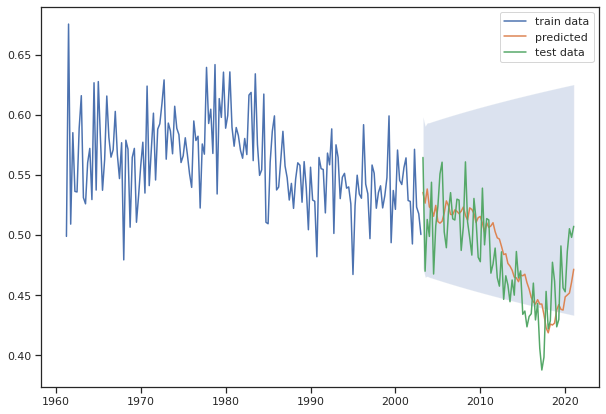

In [42]:
# Graficar datos de entrenamiento, test, con rolling forecast
# Plot past
plt.figure(figsize=(10, 7))
plt.plot(spotify_train.index, spotify_train['valence'], label='train data');

# Graficar la predicción como una línea
plt.plot(dates_test, predictions_rolling, label='predicted');
plt.plot(spotify_test['valence'], label='test data')

# Sombra en los intervalos de confianza
plt.fill_between(dates_test, v_conf_int['lower valence'], v_conf_int['upper valence'], alpha=0.2);

# Plot legend and show figure
plt.legend();

In [43]:
# Mean Absolute Error and Mean Squared Error
v_mae = mean_absolute_error(spotify_test['valence'], predictions_rolling)
v_mse = mean_squared_error(spotify_test['valence'], predictions_rolling)
v_rmse = sqrt(v_mse)
print('MSE: %f' % v_mae)
print('MAE: %f' % v_mse)
print('RMSE: %f' % v_rmse)

MSE: 0.024020
MAE: 0.000814
RMSE: 0.028525
